# IPAI Homework 6. Video indexing
Work done by Pavel Tishkin, p.tishkin@innopolis.university

## Prerequizites

In [1]:
!pip install mediapipe
!pip install facenet_pytorch
!pip install PIL
!pip install torch
!pip install torchvision
!pip install sklearn

## References

1) https://github.com/ytdl-org/youtube-dl/blob/master/README.md#embedding-youtube-dl
2) https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/
3) http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
4) https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/
5) https://medium.com/analytics-vidhya/face-recognition-using-openface-92f02045ca2a
6) https://github.com/timesler/facenet-pytorch
7) https://google.github.io/mediapipe/solutions/face_detection.html
8) https://stackoverflow.com/questions/43232813/convert-opencv-image-format-to-pil-image-format

## Downloading the video

Ended up downloading the video from https://yt5s.com/en10 . It was used for the work and is on my gdrive with the subtitled video. But now you are able to download the original video using the script below

In [19]:
# Following the tutorial form the official github documentation of youtube_dl

from __future__ import unicode_literals
import youtube_dl


class MyLogger(object):
    def debug(self, msg):
        pass

    def warning(self, msg):
        pass

    def error(self, msg):
        print(msg)


def my_hook(d):
    if d['status'] == 'finished':
        print('Done downloading, now converting ...')

# Got it only now how to download in 1920 x 1080
ydl_opts = {
    'format': '137',
    'logger': MyLogger(),
    'progress_hooks': [my_hook],
    'ffmpeg_location': 'ffmpeg/bin'
}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['https://www.youtube.com/watch?v=gOFt-sz1T2A&ab_channel=YOLO'])

Done downloading, now converting ...


## Video Processing

Face detectors summary:

- Opencv face detector barely found faces at all
- DLib face detector found a lot of faces, but stil insufficient amount and it takes a lot of time to work
- facenet_pytorch's face detector got a lot of false positives, while predicting a nice amount of faces.
- face_utils face detector barely found faces on the video
- google's mp face detector is the fastest and the best of them

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from facenet_pytorch import InceptionResnetV1
from PIL import Image
import torch
import mediapipe as mp
from torchvision import transforms
from sklearn.cluster import DBSCAN

### Finding and embedding faces

In [2]:
def get_coordinates(box):
    # Getting coordinates from the relative coordinates of the box
    relbb = box.location_data.relative_bounding_box
    x_min = abs(int(relbb.xmin * 1920))
    x_max = abs(x_min + int(relbb.width * 1920))
    y_min = abs(int(relbb.ymin * 1080))
    y_max = abs(y_min + int(relbb.height * 1080))
    return x_min, y_min, x_max, y_max

In [3]:
# Initializing models
mp_face_detection = mp.solutions.face_detection
cap = cv2.VideoCapture('video.mp4')
resnet = InceptionResnetV1(pretrained='vggface2').eval()

# Initializing holders of data
embeddings = torch.Tensor()
times = []
face_imgs = []

# transforms for torch model
transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
]
)
i = 0

with mp_face_detection.FaceDetection(
    model_selection=1, min_detection_confidence=0.7) as face_detection:
    with torch.no_grad():
        while cap.isOpened:
            ret, frame = cap.read()
            i+=1
            if ret:
                
                # Detecting faces
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                faces = face_detection.process(frame)
                if faces.detections != None:
                    for face in faces.detections:
                        
                        # Extracting coordinates
                        x_min, y_min, x_max, y_max = get_coordinates(face)
                        
                        # Cutting faces 
                        # y coords are first, thanks opencv very cool
                        img = frame[y_min:y_max, x_min:x_max]
                        
                        # Saving images of the faces
                        face_imgs.append(img)
                        
                        # Making PIL image and transforming
                        pil_img = Image.fromarray(img)
                        pil_img = transform(pil_img).unsqueeze(0)
                        
                        # Getting and saving embedding
                        embedding =  resnet(pil_img)
                        embeddings = torch.cat((embeddings, embedding))
                        
                        # Writing time in seconds. Cast to ints because we mostly care about second but not a frame in which the person was
                        times.append(int(i/25))
            else:
                break

cap.release()
cv2.destroyAllWindows()

c:\users\pavel\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Clustering

In [4]:
# Clustering and getting labels
clustering = DBSCAN(eps=0.6, min_samples=10, metric='euclidean').fit(embeddings.numpy())
labels = clustering.labels_

### Showing results

In [5]:
class Person():
    def __init__(self, num, timestamps, picture):
        # Person consists of a number, image and times on a screen
        self.num = num
        self.timestamps = timestamps
        self.picture = picture
        self.calculate_times()
        
    def calculate_times(self):
        
        # Result - string of times of a person
        result = ''
        
        # start and of appearance on the screen
        start_t = self.timestamps[0]
        end_t = self.timestamps[0]
        
        # Iterating through timestamps
        for t in self.timestamps[1:]:
            
            # if person was on the screen for less than or equal to 1s with respect to the previous frame, they were there
            if (t-end_t)<=1:
                end_t = t
            else:
                # Else, writing to result and resetting position
                result+=self.get_times(start_t, end_t)
                start_t = t
                end_t = t
                
        # Writing final timestamps
        result += self.get_times(start_t, end_t)
        self.times = result
        
    def get_times(self, start_time, end_time):
        
        # Case of the same start and end
        if start_time%60 == end_time%60:
            result = '%02d:%02d ' % (start_time//60, start_time%60)
            
        # Case of different start and end
        else:
            result = '%02d:%02d-%02d:%02d; ' % (start_time//60, start_time%60, end_time//60, end_time%60)
        return result

Person 0
 Timestamps: 00:05 00:08-00:09; 00:17-00:18; 00:21-00:22; 00:26-00:31; 00:34 00:47-00:48; 00:53-00:56; 00:59-01:06; 01:09-01:11; 01:13 01:19-01:23; 01:25-01:26; 01:28-01:34; 01:39 01:49-01:50; 02:00-02:06; 02:08-02:09; 02:16-02:23; 02:51 02:53 03:17-03:18; 03:20-03:22; 03:28-03:30; 03:33 


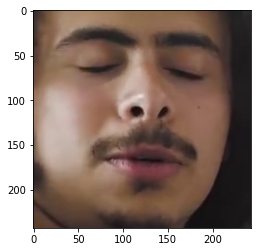

Person 1
 Timestamps: 00:16-00:17; 


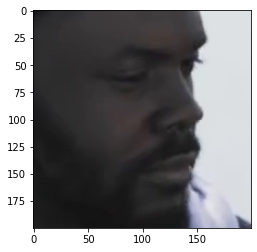

Person 2
 Timestamps: 00:29 


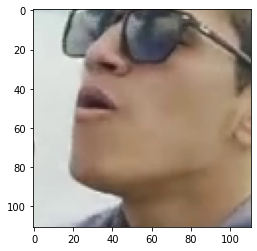

Person 3
 Timestamps: 00:29-00:31; 


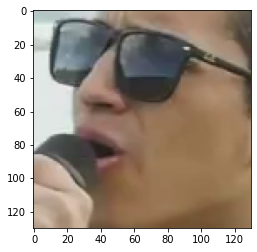

Person 4
 Timestamps: 00:32-00:33; 


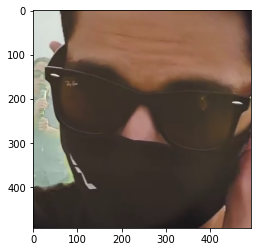

Person 5
 Timestamps: 00:34-00:37; 00:48-00:49; 01:00-01:01; 01:11-01:16; 01:27-01:28; 01:35-01:37; 01:42 01:44 02:03-02:06; 02:08 02:36-02:38; 02:44-02:46; 02:56-03:00; 03:32 


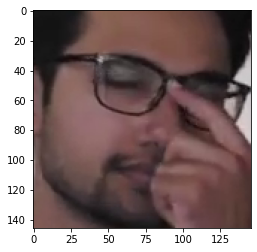

Person 6
 Timestamps: 00:44-00:45; 


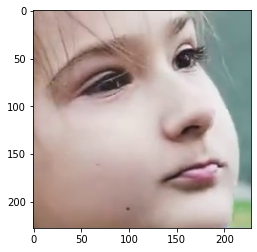

Person 7
 Timestamps: 00:49-00:50; 


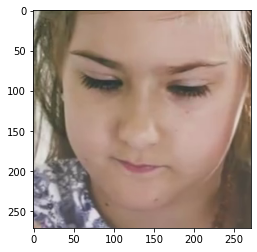

Person 8
 Timestamps: 00:56-00:58; 


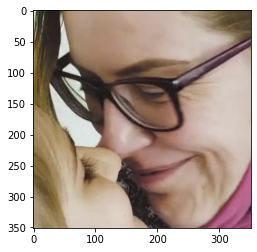

Person 9
 Timestamps: 01:37-01:39; 


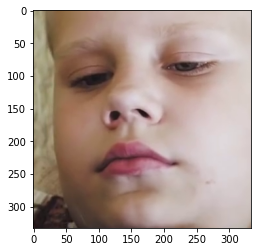

Person 10
 Timestamps: 01:39-01:41; 


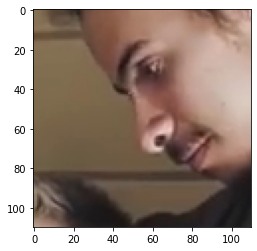

Person 11
 Timestamps: 01:50-01:51; 


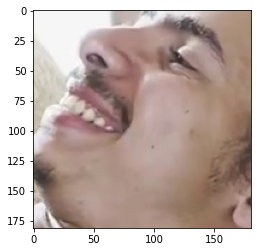

Person 12
 Timestamps: 01:58-02:00; 


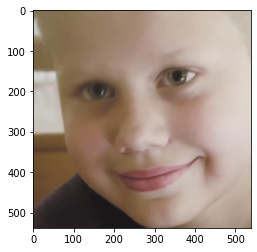

Person 13
 Timestamps: 02:03-02:06; 


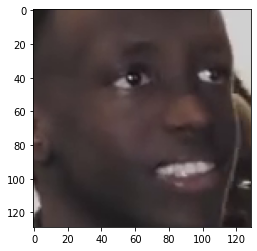

Person 14
 Timestamps: 02:03-02:05; 


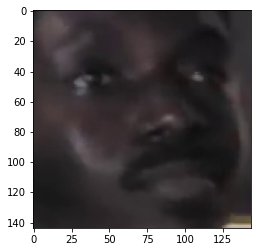

Person 15
 Timestamps: 02:05 


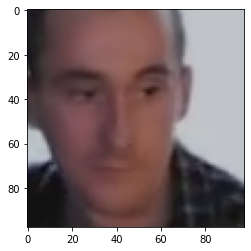

Person 16
 Timestamps: 02:09 


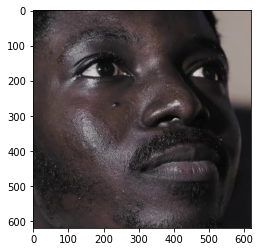

Person 17
 Timestamps: 02:10-02:11; 02:13-02:16; 02:20-02:23; 02:29-02:30; 02:33 


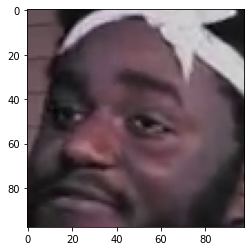

Person 18
 Timestamps: 02:11-02:13; 02:19 02:21 


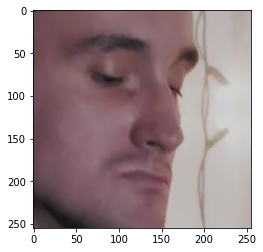

Person 19
 Timestamps: 02:20 02:24-02:25; 02:29-02:30; 02:32-02:34; 


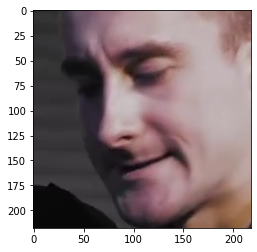

Person 20
 Timestamps: 02:26-02:28; 02:30-02:32; 02:35-02:36; 


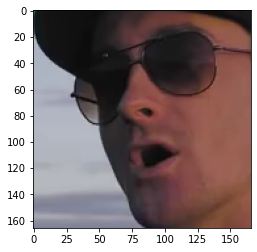

Person 21
 Timestamps: 02:38-02:39; 


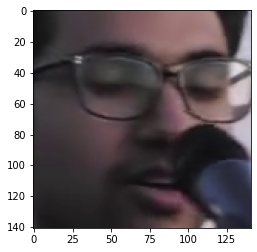

Person 22
 Timestamps: 02:39-02:41; 02:46-02:47; 02:53-02:54; 03:13-03:15; 


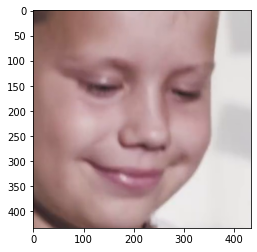

Person 23
 Timestamps: 02:56 


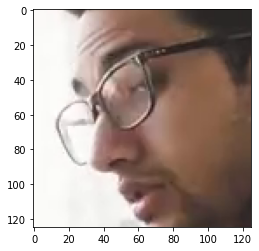

Person 24
 Timestamps: 03:02-03:03; 


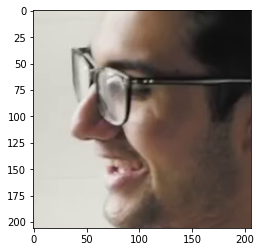

Person 25
 Timestamps: 03:30-03:31; 


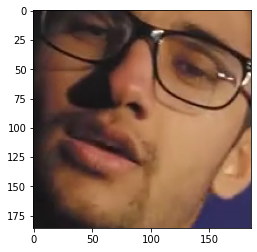

Person -1
 Timestamps: 00:03-00:04; 00:09 00:16 00:20-00:22; 00:24 00:26-00:27; 00:29-00:31; 00:34 00:36-00:37; 00:44-00:48; 00:52-00:54; 00:59-01:02; 01:04-01:05; 01:09-01:11; 01:13-01:14; 01:19 01:22-01:24; 01:26 01:31 01:39-01:44; 01:48-01:51; 01:56 02:01 02:03 02:05-02:06; 02:08-02:09; 02:15 02:17-02:23; 02:27-02:28; 02:31-02:32; 02:34-02:35; 02:37-02:38; 02:50-02:51; 02:53 02:56 03:00-03:01; 03:06-03:07; 03:10 03:12 03:16-03:17; 03:20-03:22; 03:24 03:28-03:33; 


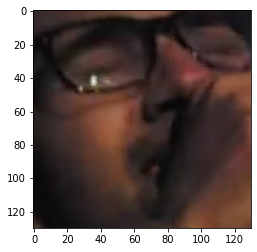

In [14]:
for l in set(labels):
    
    # Getting indx of the person
    cluster = np.argwhere(labels == l).flatten().tolist()
    
    # Getting random representational image
    img_idx = np.random.choice(cluster)
    img = face_imgs[img_idx]
    
    # getting all the timmes of appearance
    t = [times[i] for i in cluster]
    person = Person(l, t, img)
    # printing
    print(f'Person {person.num}\n Timestamps: {person.times}')
    plt.imshow(person.picture)
    plt.show()

### Generating subtitles

In [7]:
def get_vtt_times(start_time, end_time):
    # Crude but works
    # Gets times in vtt format
    # If the same int time in seconds - show the subtitle during that period
        if start_time%60 == end_time%60:
            result = '%02d:%02d.001 --> %02d:%02d.999\n' % (start_time//60, start_time%60, start_time//60, start_time%60)
        else:
            # Show on the whole period
            result = '%02d:%02d.000 --> %02d:%02d.000\n ' % (start_time//60, start_time%60, end_time//60, end_time%60)
        return result

def get_people(ppl):
    # Crude but works
    # Formatting people for subtitles
    result = ''
    for p in ppl:
        if p == -1:
            result+='Unknown person '
        else:
            result+=f'Person{p+1} '
    return result

In [8]:
# Crude but works
result = ['WEBVTT\n',]
previous_labels = []
# Initializing start and end of the timeframe i
start_time = times[0]
end_time = times[0]
# Initializing previous labesl at timeframe i
current_idx = np.argwhere(np.array(times)==times[0])
previous_labels = [labels[i][0] for i in current_idx] 

for t in sorted(set(times)):
    
    # getting all the labels for the current timeframe
    current_idx = np.argwhere(np.array(times)==t)
    current_labels = [labels[i][0] for i in current_idx]
    
    # If they match -> shift the end of the timeframe. Also, some small error of 1sec is plausible
    if set(current_labels) == set(previous_labels) and (t - end_time<=2):
        end_time = t
    else:
        
        # Writing to the result
        result.append(f'{len(result)}\n' + get_vtt_times(start_time, end_time) + get_people(set(previous_labels)) + '\n')
        previous_labels = current_labels
        start_time = t
        end_time = t
        

### Writing subtitles

In [9]:
res = '\n'.join(result)
with open('result.vtt', 'w+') as f:
    f.write(res)

## Link to the video
https://drive.google.com/drive/folders/1CecSNWqdbE1trECBYc77xMGvBtP3uXaZ?usp=sharing

In the drive, you can find a video with subtitles - final.mp4, video I used in this work - video_I_downloaded.mp4, and subtitles: result.vtt